# Imports

In [1]:
import gym
import rubiks
import rubiks2

import random
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os 
import copy
import time

from collections import defaultdict, deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from replay_memories import ReplayMemory, PrioritizedReplayMemory
from networks import DQN, DuelingDQN, DuelingDQNHER

from tqdm import tqdm_notebook
from EXP3S import EXP3S

from MCTS import MonteCarloSearchTree

from superflip import superflip_set

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Torch Version: ", torch.__version__)

Device:  cuda
Torch Version:  1.0.1.post2


In [3]:
model = DuelingDQN(144, [4096, 2048, 512], 6, F.elu)
os.mkdir('models/Random/')
torch.save(model, 'models/Random/' + "model.pt")

FileExistsError: [Errno 17] File exists: 'models/Random/'

# Epsilon

In [4]:
# Epsilon decay
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100

epsilon_by_exponential_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)

epsilon_by_linear_step = lambda step_idx: epsilon_final + (epsilon_start-epsilon_final)*((epsilon_decay-step_idx)/epsilon_decay) if step_idx < epsilon_decay else epsilon_final

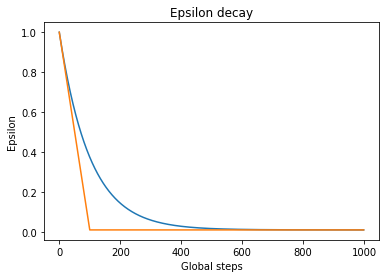

In [5]:
plt.figure
plt.title('Epsilon decay')
plt.xlabel('Global steps')
plt.ylabel('Epsilon')
plt.plot([epsilon_by_exponential_step(i) for i in range(1000)])
plt.plot([epsilon_by_linear_step(i) for i in range(1000)])

# Reward Scaling

In [6]:
# Scales rewards. Have emailed about how to implement for when there is no history or an history of 1 reward. 
# No answer as of yet, but my guess is that returning 0 will not affect the probabilites
def scale_reward(unscaled_reward, history_unscaled_rewards):
    if not history_unscaled_rewards:
        return 0

    q_lo = np.quantile(history_unscaled_rewards, 0.2)
    q_hi = np.quantile(history_unscaled_rewards, 0.8)
    
    if unscaled_reward < q_lo:
        return -1
    
    if unscaled_reward > q_hi:
        return 1
    
    if q_lo == q_hi:
        return 0
    
    return (2*(unscaled_reward - q_lo)/(q_hi-q_lo)) - 1

In [7]:
# Computes the q-values of an action in a state
def compute_q_val(model, state, action):
    qactions = model(state)
    return torch.gather(qactions,1,action.view(-1,1))

In [8]:
# Computes the target. When done, 0 is added to the reward as there is no next state.
def compute_target_dqn(model, reward, next_state, done, gamma):
    return reward + gamma * model(next_state).max(1)[0] * (1-done)

# Computes the target. When done, 0 is added to the reward as there is no next state. But now for Double DQN
def compute_target_ddqn(model, target_model, reward, next_state, done, gamma):
    a = model(next_state)
    return reward.view(-1,1) + gamma * torch.gather(target_model(next_state),1,model(next_state).max(1)[1].view(-1,1)) * (1-done).view(-1,1)

# Training classes

In [9]:
class Train(object):
    def __init__(self, architecture, duelingDQN, doubleDQN, lr, frames, batch_size, gamma, capacity_increase, 
                        tau, non_linearity,
                        verbose=False, load_path=None, save_path=None, seed=None):
        
        self.make_path(save_path)
        
        self.set_seed(seed)
        
        # Arrays to keep track of losses and accuracies over time
        self.losses = []
        self.accuracies = []
        
        # Global steps keeps track of the total number of optimisation steps
        self.global_steps = 0
        # Local steps keeps track of number of optimisation steps within a task
        self.local_steps = 0
        self.steps_without_improvement = 0
        self.best_accuracy = 0
        
        # Epsilon exponential decay
        self.epsilon_start = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 10000
        
        self.frames = frames
        
        self.verbose = verbose
        
        self.criterion = torch.nn.SmoothL1Loss(reduce=False)
    
    def make_path(self, save_path):
        # If the directory does not exist, make one
        if save_path:
            if not os.path.isdir(save_path):
                os.mkdir(save_path)
                
    def set_seed(self, seed):
        # If a seed is set, set the seed for all sources of randomness
        if seed:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
    
    def calculate_max_moves_from_difficulty(self, difficulty):
        return difficulty // 6 + 1
    
    def calculate_max_moves_from_scrambles(self, scrambles):
        return min(scrambles, 14)
            
    def initialise_models(self, load_path):
        raise NotImplementedError('Override initialise_models method in child class')
    
    def train(self):
        raise NotImplementedError('Override train method in child class')

# Handcrafted Curricula

In [1]:
class TrainHandcrafted(Train):
    def __init__(self, architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, frames, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity,
                        verbose=False, load_path=None, save_path=None, seed=None):
        super().__init__(architecture, duelingDQN, doubleDQN, lr, frames, batch_size, gamma, capacity_increase, tau, non_linearity,
                        verbose=verbose, load_path=load_path, save_path=save_path, seed=seed)
        
        print(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, frames, batch_size, gamma,
                        threshold, evaluation_frequency, tau, curriculum, non_linearity)
        print([cap(1) for cap in capacity_increase])
        
        # Difficulty the problem starts with
#         self.difficulty = 0
        self.difficulty = 1
        
        # Set initial maximum number of tries
        self.initial_max_tries = 14
        
        # Initialise current and target model
        self.initialise_models(load_path)
        self.models_to_device()
        
        # Initialise replay memory
        self.memoryCapacity = memoryCapacity
        self.initialise_memory(prioritizedReplayMemory, self.memoryCapacity, alpha)
        
        # Initialise optimiser
        self.optimizer = optim.Adam(self.current_model.parameters(), lr=lr)
        
        self.curriculum = curriculum
        self.batch_size = batch_size
        self.gamma = gamma
        self.save_path = save_path
        self.tau = tau
        self.evaluation_frequency = evaluation_frequency
        self.threshold = threshold
        self.capacity_increase = capacity_increase
        self.lr = lr
        
        self.steps = []
        self.changes = []
        
    def models_to_device(self):
        # Decide what device to put the models on
        if torch.cuda.is_available():
            self.current_model.to('cuda')
            self.target_model.to('cuda')
        else:
            self.current_model.to('cpu')
            self.target_model.to('cpu')
            
    def initialise_memory(self, prioritizedReplayMemory, memoryCapacity, alpha):
        # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
        if prioritizedReplayMemory:
            self.memory = PrioritizedReplayMemory(int(memoryCapacity), alpha)
        else:
            self.memory = ReplayMemory(int(memoryCapacity))
    
    def initialise_models(self, load_path):
        # If a path with a model is provided certain variables are loaded
        if load_path:
            self.current_model = torch.load(load_path + 'model.pt')
            self.target_model = copy.deepcopy(current_model)
        else:
            # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
            state_size = env.size**2 * 6**2

            # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
            self.output_nodes = 12
            if env.size == 2:
                self.output_nodes = 6

            # Initialising either a network with dueling architecture or regular network
            if duelingDQN:
                self.current_model = DuelingDQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DuelingDQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
            else:
                self.current_model = DQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
    
    def save_model_parameters(self):
        if self.save_path:
            torch.save(self.current_model, self.save_path + "model.pt")
                
    def get_state(self):
        # Decide what state to show the network next depending on the curriculum
        state = None
        max_tries = None
        
        if curriculum is 'Naive':
            state = env.reset(self.difficulty)
            max_tries = self.calculate_max_moves_from_scrambles(self.difficulty)
            
        elif curriculum is 'LBF':
            p = np.random.rand()
            
            if p < 0.2:
                scrambles = np.random.randint(1, 1000)
                state = env.reset(scrambles)
                max_tries = self.calculate_max_moves_from_scrambles(scrambles)
                
            else:
                state = env.reset(self.difficulty)
                max_tries = self.calculate_max_moves_from_scrambles(self.difficulty)
                
        elif curriculum is 'Mixed':
            scrambles = np.random.randint(1,1000)
            state = env.curriculum_reset(scrambles)
            max_tries = self.calculate_max_moves_from_scrambles(scrambles)
            
        else:
            scrambles = 1000
            state = env.reset(scrambles)
            max_tries = self.calculate_max_moves_from_scrambles(scrambles)
            
        return state, max_tries + self.initial_max_tries
    
    def train_dqn(self):
        if len(self.memory)<self.batch_size:
            return None

        batch, indices, weights = self.memory.sample(self.batch_size, self.local_steps, device)

        state, action, reward, next_state, done = zip(*batch)

        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        done = torch.tensor(done, dtype=torch.float32, device=device)

        weights.to(device)

        self.optimizer.zero_grad()

        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)        

#         difference = (q_val - target.view(-1,1))

#         # Weights is 1 for normal replay buffer so nothing changes
#         # McAleer divides the loss by the number of moves of the scramble here. Might not make sense in non-MCTS setting
#         loss = difference.pow(2) * weights
#         loss = loss.mean()

        loss = self.criterion(q_val, target.view(-1,1)) * weights.unsqueeze(1)

        prios = loss + 1e-5
        loss = loss.mean()

        loss.backward()
        # Also taken from higgsfield
        self.memory.update_priorities(indices, prios.detach().squeeze().abs().cpu().numpy().tolist())
        self.optimizer.step()

        return loss.item()
    
    def train_without_replay(self, state, action, next_state, reward, done):
        self.optimizer.zero_grad()

        state = torch.tensor([state], dtype=torch.float32, device=device)
        action = torch.tensor([action], dtype=torch.long, device=device)
        next_state = torch.tensor([next_state], dtype=torch.float32, device=device)
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        done = torch.tensor([done], dtype=torch.float32, device=device)

        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)

        difference = (q_val - target.view(-1,1))

        loss = difference.pow(2)
        loss = loss.mean()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self):
        accuracy = 0.0
        try:
            epsilon_by_step = lambda step_idx: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step_idx / self.epsilon_decay)
            for frame_idx in tqdm_notebook(range(self.frames)):
                frame_losses = []
                
                # Main RL loop
                state, max_tries = self.get_state()
                done = 0
                tries = 0
                
                while tries < max_tries and not done:
                    epsilon = epsilon_by_step(self.local_steps)
                    action = self.current_model.act(state, epsilon, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)
                    self.memory.push((state, action, reward, next_state, done))
                    
                    # Directly train on last tuple if no replay buffer is uses
                    if not replay:
                        
                        loss = self.train_without_replay(state, action, next_state, reward, done)
                        
                    # Use replay memory to train
                    if replay:
                        loss = self.train_dqn()
                        
                    self.global_steps += 1
#                     if self.global_steps == self.frames:
#                         break
                        
                    self.local_steps += 1

                    state = next_state

                    tries += 1
                
                if loss:
                    frame_losses.append(loss)   
                
                # Target model becomes the current model (Mnih)
                if self.global_steps % self.tau == 0:
                    self.target_model.load_state_dict(self.current_model.state_dict())
                    self.save_model_parameters()
                
                
                # Current model evaluated in raw fashion, i.e. no additional structures such as MCTS or second best
                if self.global_steps % self.evaluation_frequency == 0 and self.curriculum is not None:
                    total_done = 0
                    for i in range(100):
                        state = env.reset(self.difficulty)
                        max_tries = self.calculate_max_moves_from_scrambles(self.difficulty) + self.initial_max_tries
                        
    
                        done = 0
                        tries = 0
                        
                        while tries < max_tries and not done:
                            action = self.current_model.act(state, 0.0, [0]*env.action_space.n, device)
                            next_state, reward, done, info = env.step(action)
                            state = next_state    
                        
                            total_done += done
                            tries += 1
                        
                    accuracy = total_done/100
                    self.accuracies.append(accuracy)
                    self.steps.append(self.global_steps)
                    
                    # Keep track of the rate of improvement
                    # Reove this part?
                    if accuracy>self.best_accuracy:
                        self.best_accuracy = accuracy
                        self.steps_without_improvement = 0
                    else:
                        self.steps_without_improvement += 1
                        
                    if self.steps_without_improvement > 100:
                        break
                    
                    # Increment the current difficulty when the accuracy threshold is surpassed
                    if accuracy >= self.threshold:
                        self.steps_without_improvement = 0
                        self.best_accuracy = 0
                        self.difficulty += 1
                        self.local_steps = 0
                        self.changes.append(self.global_steps)

                        epsilon_by_step = lambda step_idx: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step_idx / self.epsilon_decay)
                    
                    # Print information
                    if self.verbose:
                        clear_output(True)
                        print("Frame: ", frame_idx, "Global steps: ", self.global_steps)
#                         print("Difficulty: ", self.difficulty, "Max tries:", self.calculate_max_moves_from_difficulty(self.difficulty))
                        print("Difficulty: ", self.difficulty, "Max tries:", self.calculate_max_moves_from_scrambles(self.difficulty))
                        print("Memory: ", len(self.memory), "epsilon: ", epsilon, "local steps: ", self.local_steps)
                        print("Accuracy: ", accuracy, "Threshold: ", self.threshold)
                        print("Steps without improvement: ", self.steps_without_improvement, self.best_accuracy)
                        print(self.current_model)
                        
            self.losses.append(np.average(epoch_losses))
            
        except KeyboardInterrupt:
            pass
        
        if self.save_path:
            torch.save(self.current_model, self.save_path + "model.pt")
        
        return self.difficulty, accuracy, self.accuracies, self.steps, self.changes

NameError: name 'Train' is not defined

In [11]:
class TrainAutomated(Train):
    def __init__(self, architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity, PG_eta=10e-3, PG_beta=0, PG_epsilon=0.05,
                        verbose=False, load_path=None, save_path=None, seed=None):
        super().__init__(architecture, duelingDQN, doubleDQN, lr, epochs, batch_size, gamma, capacity_increase, tau, non_linearity,
                        verbose=verbose, load_path=load_path, save_path=save_path, seed=seed)
        
        print(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, epochs, batch_size, gamma,
                        threshold, evaluation_frequency, tau, curriculum, non_linearity)
        

        
        # Initialise current and target model
        self.initialise_models(load_path)
        self.models_to_device()

        # Initialise optimiser
        self.optimizer = optim.Adam(self.current_model.parameters(), lr=lr)
        
        # Initialise replay memory
        self.memoryCapacity = memoryCapacity
        self.initialise_memory(prioritizedReplayMemory, self.memoryCapacity, alpha)

        self.gamma = gamma
        self.save_path = save_path
        self.tau = tau
        self.evaluation_frequency = evaluation_frequency

        self.capacity_increase = capacity_increase
        self.lr = lr
        self.batch_size = batch_size

        self.exp3s = exp3s = EXP3S(14, PG_eta, PG_beta, PG_epsilon)
    
        self.history_unscaled_rewards = deque(maxlen=100)
    
    def models_to_device(self):
        # Decide what device to put the models on
        if torch.cuda.is_available():
            self.current_model.to('cuda')
            self.target_model.to('cuda')
        else:
            self.current_model.to('cpu')
            self.target_model.to('cpu')
        
    def initialise_models(self, load_path):
        # If a path with a model is provided certain variables are loaded
        if load_path:
            self.current_model = torch.load(load_path + 'model.pt')
            self.target_model = copy.deepcopy(current_model)
        else:
            # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
            state_size = env.size**2 * 6**2

            # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
            self.output_nodes = 12
            if env.size == 2:
                self.output_nodes = 6

            # Initialising either a network with dueling architecture or regular network
            if duelingDQN:
                self.current_model = DuelingDQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DuelingDQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
            else:
                self.current_model = DQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
    
    def initialise_memory(self, prioritizedReplayMemory, memoryCapacity, alpha):
        # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
        if prioritizedReplayMemory:
            self.memory = PrioritizedReplayMemory(int(memoryCapacity), alpha)
        else:
            self.memory = ReplayMemory(int(memoryCapacity))
    
    def save_model_parameters(self):
        if self.save_path:
            torch.save(self.current_model, self.save_path + "model.pt")
                
    def get_state(self):
        # Decide what state to show the network next depending on the curriculum
        scrambles = np.random.choice([i + 1 for i in range(14)],size=1, p=self.exp3s.sample_probabilities())[0]

        state = env.reset(scrambles)
        
        return state, scrambles
    
    def train_dqn(self):
        if len(self.memory)<self.batch_size:
            return None, None

        batch, indices, weights = self.memory.sample(self.batch_size, self.local_steps, device)

        state, action, reward, next_state, done = zip(*batch)

        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        done = torch.tensor(done, dtype=torch.float32, device=device)

        weights.to(device)

        self.optimizer.zero_grad()

        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)

        difference = (q_val - target.view(-1,1))

        loss_before = difference.pow(2)*weights
        loss_before = loss_before.mean()

        loss_before.backward()
        self.memory.update_priorities(indices, difference.detach().squeeze().abs().cpu().numpy().tolist())
        self.optimizer.step()
        
        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)

        difference = (q_val - target.view(-1,1))

        loss_after = difference.pow(2)*weights
        loss_after = loss_after.mean()

        nu_PG = (loss_before - loss_after).item()

        return loss_before.item(), nu_PG
        
    def train(self):
        accuracy = 0.0
        
        try:
            epsilon_by_step = lambda step_idx: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step_idx / self.epsilon_decay)
            for epoch in tqdm_notebook(range(self.epochs)):
                epoch_losses = []
                
                # Main RL loop
                state, max_tries = self.get_state()
                done = 0
                tries = 0
                
                while tries < max_tries + 14 and not done:
                    epsilon = epsilon_by_step(self.local_steps)
                    action = self.current_model.act(state, epsilon, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)
                    self.memory.push((state, action, reward, next_state, done))
                
                    state = next_state
                    tries += 1
                    
                loss, nu_PG = self.train_dqn()
                
                if loss:
                    reward = scale_reward(nu_PG, self.history_unscaled_rewards)
            
                    self.history_unscaled_rewards.append(nu_PG)
                    self.exp3s.update_weights(reward, max_tries - 1)
                
                self.global_steps += 1
                
                if epoch%1000==0:
                    clear_output(True)
                    print(np.array(self.exp3s.sample_probabilities()))
                    print((-np.array(self.exp3s.sample_probabilities())).argsort()[:14])
                    
                    env.seed(420)
                    total_done = 0
                    for i in range(14):
                        for j in range(100):
                            state = env.reset(i + 1)
                            max_tries = self.calculate_max_moves_from_scrambles(i + 1)
                        
                            done = 0
                            tries = 0
                        
                            while tries < max_tries and not done:
                                action = self.current_model.act(state, 0.0, [0]*env.action_space.n, device)
                                next_state, reward, done, info = env.step(action)
                                state = next_state    

                                total_done += done
                                tries += 1
                    env.seed(None)
                        
                    accuracy = total_done/1400
                    print(accuracy)
        except KeyboardInterrupt:
            pass

In [14]:
np.set_printoptions(4)
experiments = []
epochs = 5000000

experiments.append(["LBF_14_PG", [4096, 2048, 512], True, True, True, False, 0.5, 10000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'LBF', F.leaky_relu])
experiments.append(["Mixed_14_PG", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'Mixed', F.leaky_relu])
experiments.append(["Naive_14_PG", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'Naive', F.leaky_relu])
experiments.append(["None_14_PG", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'None', F.leaky_relu])

for experiment in experiments:
    architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = experiment[1:]

    env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)

    trainer = TrainAutomated(architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment[0]+'/', seed=40, verbose=False)
    
    difficulty, accuracy, accuracies, steps, changes = trainer.train()

    print(difficulty, accuracy)
    
    plt.figure()
    plt.plot(steps, accuracies)
    plt.xlabel('steps')
    plt.ylabel('Accuracy')
    for change in changes:
        idx = steps.index(change)
        plt.plot(steps[idx], accuracies[idx], 'ro')
    plt.show()

[0.0036 0.0036 0.0036 0.0037 0.0039 0.0075 0.0043 0.0059 0.941  0.0038
 0.0065 0.0053 0.0037 0.0036]
[ 8  5 10  7 11  6  4  9  3 12  0 13  2  1]
0.13357142857142856


TypeError: 'NoneType' object is not iterable

In [13]:
class GridSearchRangeParameter(object):
    def __init__(self, minimum_value, maximum_value, dtype):
        self.minimum_value = minimum_value
        self.maximum_value = maximum_value
        self.dtype = dtype
    
    def sample(self):
        if self.dtype=='float':
            return np.random.uniform(low=self.minimum_value, high=self.maximum_value, size=1)[0]
        if self.dtype=='int':
            return np.random.randint(low=self.minimum_value, high=self.maximum_value, size=1)[0]
        else:
            raise Error

In [109]:
class GridSearchDiscreteParameter(object):
    def __init__(self, parameter_value_list):
        self.parameter_value_list = parameter_value_list
    
    def sample(self):
        return self.parameter_value_list[np.random.randint(len(self.parameter_value_list))]

In [110]:
def grid_search(parameter_list, repetitions):
    epochs = 10000
    for i in range(repetitions):
        sampled_parameter_values = []
        np.random.seed(i)
        for parameter in parameter_list:
            sampled_parameter_values.append(parameter.sample())
        env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)
        architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = sampled_parameter_values
        experiment_name = str(hash(np.array(sampled_parameter_values).tostring()))
        trainer = TrainHandcrafted(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment_name+'/', seed=420, verbose=False)
        difficulty, accuracy, accuracies, steps, changes = trainer.train()
        
        print(experiment_name)
        print('difficulty: ', difficulty)
        print('accuracy: ', accuracy)

In [111]:
parameter_list = [None]*15
# Architecture
parameter_list[0] = GridSearchDiscreteParameter([[4096, 2048, 512],[2048, 1024, 256]])
#Dueling DQN
parameter_list[1] = GridSearchDiscreteParameter([True, False])
#Double DQN
parameter_list[2] = GridSearchDiscreteParameter([True, False])
#Prioritized Replay Sampling
parameter_list[3] = GridSearchDiscreteParameter([True, False])
#Alpha
parameter_list[4] = GridSearchRangeParameter(0.5, 0.99, 'float')
#Memory Capacity
parameter_list[5] = GridSearchRangeParameter(1000, 100000, 'int')
#Learning Rate
parameter_list[6] = GridSearchRangeParameter(1e-3, 1e-2, 'float')
#Batch Size
parameter_list[7] = GridSearchRangeParameter(2, 128, 'int')
#Gamma
parameter_list[8] = GridSearchRangeParameter(0.8, 0.99, 'float')
#Capacity Increase 
parameter_list[9] = GridSearchDiscreteParameter([[lambda x: 0, lambda x: 0, lambda x: 0],[lambda x: 1, lambda x: 1, lambda x: 1]])
#Threshold
parameter_list[10] = GridSearchRangeParameter(0.8, 0.99, 'float')
#Evaluation Frequency
parameter_list[11] = GridSearchRangeParameter(100, 1000, 'int')
#Tau
parameter_list[12] = GridSearchRangeParameter(100, 1000, 'int')
#curriculum
parameter_list[13] = GridSearchDiscreteParameter(['LBF', 'Naive', 'Mixed'])
#Non-linearity
parameter_list[14] = GridSearchDiscreteParameter([F.relu, F.sigmoid, F.leaky_relu])

grid_search(parameter_list, 100)
architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, 
lr, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = sampled_parameter_values
        

[4096, 2048, 512] False False True 0.7953540542751054 96939 0.00862526564905713 10000 85 0.9227198814826647 0.8565315752434498 572 700 LBF <function leaky_relu at 0x7f49a30f6e18>
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

2498588749855561335
difficulty:  0
accuracy:  0.0
[2048, 1024, 256] False True True 0.500056043660499 74349 0.0023208030173540173 10000 18 0.875350338186245 0.8656565381381791 490 381 Mixed <function relu at 0x7f49a30f66a8>
[1, 1, 1]


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

6104363375521207664
difficulty:  0
accuracy:  0.0
[4096, 2048, 512] False False True 0.7693346141605675 85434 0.005362741871053802 10000 9 0.8627636159907361 0.9327839113597682 147 931 Mixed <function relu at 0x7f49a30f66a8>
[1, 1, 1]


KeyboardInterrupt: 

In [106]:
def hypotheses(hypothesis_list):
    epochs = 50000
    for hypothesis in hypothesis_list:
        
        env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)
        architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = hypothesis
        experiment_name = str(hash(np.array(hypothesis).tostring()))
        trainer = TrainHandcrafted(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment_name+'/', seed=420, verbose=False)
        difficulty, accuracy = trainer.train()
        
        print(experiment_name)
        print('difficulty: ', difficulty)
        print('accuracy: ', accuracy)
        test(experiment_name, False, True, False)

In [29]:
hypothesis_list =[]
hypothesis_list.append([[4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'Mixed', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.sigmoid])
hypothesis_list.append([[2048, 1024, 256], True, True, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], False, True, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, False, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, True, False, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], False, False, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], False, True, False, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, False, False, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], False, False, False, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, True, True, 0.7, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, 128, 0.9, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list.append([[4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.9, 100, 1000, 'LBF', F.elu])
hypotheses(hypothesis_list)

NameError: name 'hypotheses' is not defined

In [111]:
hypothesis_list2 = []
hypothesis_list2.append([[4096, 2048, 512], True, True, True, 0.5, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list2.append([[4096, 2048, 512], False, True, True, 0.5, 100000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypothesis_list2.append([[4096, 2048, 512], True, True, False, 0.5, 1000, 1e-3, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'LBF', F.elu])
hypotheses(hypothesis_list2)

[4096, 2048, 512] True True True 0.5 100000 0.001 50000 128 0.99 0.95 100 1000 LBF <function elu at 0x7f0962f64400>
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

4544755597764841836
difficulty:  40
accuracy:  0.89
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles
Second best network, 1000 scrambles
0.5603864720463654 -0.07880801456314979 [1.     1.     1.     1.     1.     0.9738 0.8796 0.7263 0.6606 0.5912
 0.5127 0.48   0.5055 0.5217] [ 1.      2.      3.      4.      5.4173 10.4231 19.5809 29.6181 43.1105
 51.0494 58.6738 60.9848 60.8417 60.5417]
[4096, 2048, 512] False True True 0.5 100000 0.001 50000 128 0.99 0.95 100 1000 LBF <function elu at 0x7f0962f64400>
[0, 0, 0]


/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:255: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:256: RuntimeWarning: invalid value encountered in true_divide


HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

-7278829126899824960
difficulty:  42
accuracy:  0.76
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles
Second best network, 1000 scrambles
0.5344937273878543 -0.06517888997389643 [1.     1.     1.     1.     1.     0.9625 0.8796 0.7591 0.5912 0.5292
 0.4655 0.5164 0.4945 0.471 ] [ 1.      2.      3.1765  4.3235  5.5118  9.5486 16.9834 27.7308 38.6173
 48.0276 54.0469 56.7746 58.9265 60.8462]
[4096, 2048, 512] True True False 0.5 1000 0.001 50000 128 0.99 0.95 100 1000 LBF <function elu at 0x7f0962f64400>
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

1242860974469482391
difficulty:  33
accuracy:  0.81
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles
Second best network, 1000 scrambles
0.32317015768353746 -0.08622007830105438 [1.     1.     1.     1.     0.9803 0.8352 0.6095 0.4416 0.4124 0.3905
 0.32   0.3018 0.2545 0.279 ] [ 1.      2.      3.2549  4.4902  6.0924 11.5785 17.1317 26.562  45.8673
 53.1776 61.9773 62.7711 65.0571 63.1169]


Frame:  24 Global steps:  700
Difficulty:  1 Max tries: 1
Memory:  700 epsilon:  0.9331621933105627 local steps:  700
Accuracy:  0.28 Threshold:  0.95
Steps without improvement:  0 0.28
DuelingDQN(
  (sharedLayers): ModuleList(
    (0): Linear(in_features=144, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=2048, bias=True)
  )
  (adv1): Linear(in_features=2048, out_features=512, bias=True)
  (adv2): Linear(in_features=512, out_features=6, bias=True)
  (v1): Linear(in_features=2048, out_features=512, bias=True)
  (v2): Linear(in_features=512, out_features=1, bias=True)
)
1 0.28


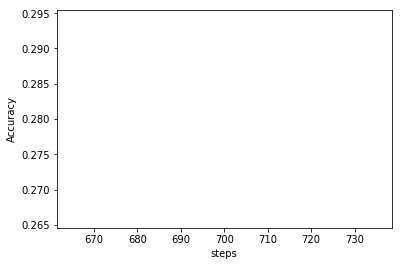

[4096, 2048, 512] True True True 0.5 100000 0.001 5000000 122 0.99 0.95 100 1000 Naive <function leaky_relu at 0x7f4e5fcfa1e0>
[1, 1, 1]


HBox(children=(IntProgress(value=0, max=5000000), HTML(value='')))

1 0.0


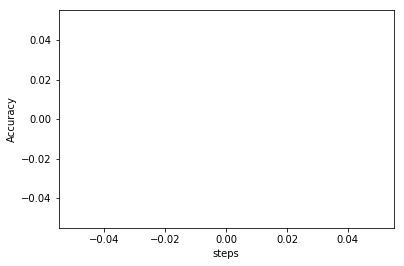

[4096, 2048, 512] True True True 0.5 100000 0.001 5000000 122 0.99 0.95 100 1000 None <function leaky_relu at 0x7f4e5fcfa1e0>
[1, 1, 1]


HBox(children=(IntProgress(value=0, max=5000000), HTML(value='')))

1 0.0


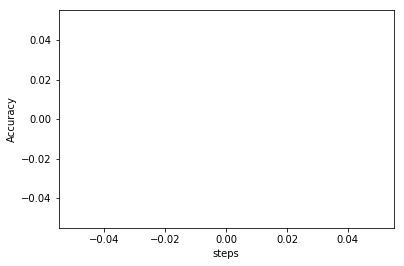

In [56]:
np.set_printoptions(4)
experiments = []
epochs = 5000000

experiments.append(["LBF_14", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'LBF', F.leaky_relu])
experiments.append(["Mixed_14", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'Mixed', F.leaky_relu])
experiments.append(["Naive_14", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'Naive', F.leaky_relu])
experiments.append(["None_14", [4096, 2048, 512], True, True, True, True, 0.5, 100000, 1e-3, epochs, 122, 0.99, [lambda x: 1, lambda x: 1, lambda x: 1], 0.95, 100, 1000, 'None', F.leaky_relu])

for experiment in experiments:
    architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = experiment[1:]

    env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)

    trainer = TrainHandcrafted(architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment[0]+'/', seed=40, verbose=True)
    
    difficulty, accuracy, accuracies, steps, changes = trainer.train()

    print(difficulty, accuracy)
    
    plt.figure()
    plt.plot(steps, accuracies)
    plt.xlabel('steps')
    plt.ylabel('Accuracy')
    for change in changes:
        idx = steps.index(change)
        plt.plot(steps[idx], accuracies[idx], 'ro')
    plt.show()

In [12]:
def maxDistance(arr): 
      
    # Used to store element to first index mapping 
    mp = {} 
  
    # Traverse elements and find maximum distance between 
    # same occurrences with the help of map. 
    maxDict = 0
    maxFirst_idx = 0
    for i in range(len(arr)): 
  
        # If this is first occurrence of element, insert its 
        # index in map 
        if arr[i] not in mp.keys(): 
            mp[arr[i]] = i 
  
        # Else update max distance 
        else: 
            if i-mp[arr[i]]>maxDict:
                maxDict = max(maxDict, i-mp[arr[i]])
                maxFirst_idx = mp[arr[i]]
  
    return maxDict, maxFirst_idx

In [13]:
def mcts_test(network, superflip, fifteen, thousand, max_tries=None):
    print('MCTS, superflip')
    c = 4.0
    nu = 10.0

    solve_rate_superflip = np.zeros(14)
    counts_superflip = np.zeros(14)
    seq_len_superflip = np.zeros(14)

    try:
        for i in range(14):
            hashes = []
            if i > 0:
                if solve_rate_superflip[i-1]==0:
                    break

            for sequence in tqdm_notebook(superflip_set):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)

                hashed_sequence = hash(str(sequence[:i+1]))

                if not hashed_sequence in hashes:

                    hashes.append(hashed_sequence)


                    counts_superflip[i] += 1

                    for j in range(i + 1):
                        env.step(sequence[j])

                    MCTS = MonteCarloSearchTree(env, network, 1.21, device, c, nu)
                    solved, solve_sequence = MCTS.search()
                    solve_rate_superflip[i] += solved

                    if solved:
                        seq_len_superflip[i] += len(solve_sequence)

    except KeyboardInterrupt:
        pass
    print('MCTS, 15 scrambles')
    solve_rate_15 = 0
    counts_15 = 0
    seq_len_15 = 0

    try:
        for i in tqdm_notebook(range(640)):
            env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)
            env.reset(15)

            counts_15 += 1

            MCTS = MonteCarloSearchTree(env, network, 1.21, device, c, nu)
            solved, solve_sequence = MCTS.search()
            solve_rate_15 += solved

            if solved:
                seq_len_15 += len(solve_sequence)

    except KeyboardInterrupt:
        pass
    
    solve_rate_1000 = 0
    counts_1000 = 0
    seq_len_1000 = 0

    try:
        for i in tqdm_notebook(range(640)):
            env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)
            env.reset(1000)

            counts_1000 += 1

            MCTS = MonteCarloSearchTree(env, network, 1.21, device, c, nu)
            solved, solve_sequence = MCTS.search()
            solve_rate_1000 += solved

            if solved:
                seq_len_1000 += len(solve_sequence)

    except KeyboardInterrupt:
        pass

    return (np.divide(solve_rate_superflip, counts_superflip),
np.divide(seq_len_superflip, solve_rate_superflip),
np.array(solve_rate_15)/np.array(counts_15),
np.array(seq_len_15)/np.array(solve_rate_15),
np.array(solve_rate_1000)/np.array(counts_1000),
np.array(seq_len_1000)/np.array(solve_rate_1000))
    
def second_best_test(network, superflip, fifteen, thousand, max_tries=None):
    print('Second best, superflip')
    c = 4.0
    nu = 10.0

    solve_rate_superflip = np.zeros(14)
    counts_superflip = np.zeros(14)
    seq_len_superflip = np.zeros(14)
    seq_len_superflip_heur = np.zeros(14)
    puzzles = []
    solution_sequences = []
    
    if superflip:
        try:
            for i in range(14):
                hashes_seqs = []
                if i > 0:
                    if solve_rate_superflip[i-1]==0:
                        break

                for sequence in tqdm_notebook(superflip_set):
                    env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)

                    hashed_sequence = hash(str(sequence[:i+1]))

                    if not hashed_sequence in hashes_seqs:

                        hashes_seqs.append(hashed_sequence)


                        counts_superflip[i] += 1
                        
                        puzzle = []
                        for j in range(i + 1):
                            env.step(int(sequence[j]))
                            puzzle.append(sequence[j])
                        
                        puzzles.append(puzzle)
                            
                        hashes = defaultdict(list)
                        done = 0
                        tries = 0
                        t = time.time()
                        state = env.get_observation()
                        hashes[hash(state.tostring())] = [0]*env.action_space.n
                        stop = False
                        
                        solution_sequence = []
                        state_hash_seq = []
                        
                        while time.time()-t<1.21 and not done and not stop:
                            mask = hashes[hash(state.tostring())]
                            state_hash_seq.append(hash(state.tostring()))
                            action = network.act(state, 0.0, mask, device)
                            solution_sequence.append(action)
                            
                            next_state, reward, done, info = env.step(action)  

                            hstate = state.copy()
                            state = next_state
                            h = hash(state.tostring())
                            if h in hashes.keys():      
                                hashes[hash(hstate.tostring())][action] = -999
                            else:
                                hashes[h] = [0]*env.action_space.n

                            tries += 1
                            if max_tries:
                                if tries >= max_tries:
                                    stop = True
                        
                        length, first_idx = maxDistance(state_hash_seq)
                        
                        while length > 0:
                            state_hash_seq = state_hash_seq[:first_idx] + state_hash_seq[first_idx + length:]
                            solution_sequence = solution_sequence[:first_idx] + solution_sequence[first_idx + length:]
                            length, first_idx = maxDistance(state_hash_seq)
                            
                        solution_sequences.append(solution_sequence)
                        solve_rate_superflip[i] += done

                        if done:
                            seq_len_superflip[i] += tries
                            seq_len_superflip_heur[i] += len(solution_sequence)

        except KeyboardInterrupt:
            pass
    
    print('Second best network, 15 scrambles')
    solve_rate_15 = 0
    counts_15 = 0
    seq_len_15 = 0
    
    if fifteen:
        try:
            for i in tqdm_notebook(range(640)):
                hashes = defaultdict(list)
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(15)
                t = time.time()

                counts_15 += 1
                
                hashes = defaultdict(list)
                done = 0
                tries = 0
                state = env.get_observation()
                hashes[hash(state.tostring())] = [0]*env.action_space.n
                while time.time()-t<1.21 and not done:
                    mask = hashes[hash(state.tostring())]
                    action = network.act(state, 0, mask, device)
                    next_state, reward, done, info = env.step(action)  

                    hstate = state.copy()
                    state = next_state
                    h = hash(state.tostring())
                    if h in hashes.keys():
                        hashes[hash(hstate.tostring())][action] = -999
                    else:
                        hashes[h] = [0]*env.action_space.n

                    tries += 1


                solve_rate_15 += done
            

                if done:
                    seq_len_15 += tries

        except KeyboardInterrupt:
            pass
    
    print('Second best network, 1000 scrambles')
    solve_rate_1000 = 0
    counts_1000 = 0
    seq_len_1000 = 0
    
    if thousand:
        try:
            for i in tqdm_notebook(range(640)):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(1000)
                t = time.time()

                counts_1000 += 1

                hashes = defaultdict(list)
                done = 0
                tries = 0
                t = time.time()
                state = env.get_observation()
                hashes[hash(state.tostring())] = [0]*env.action_space.n
                stop = False

                while time.time()-t<1.21 and not done and not stop:
                    mask = hashes[hash(state.tostring())]
                    action = network.act(state, 0.0, mask, device)

                    next_state, reward, done, info = env.step(action)  

                    hstate = state.copy()
                    state = next_state
                    h = hash(state.tostring())
                    if h in hashes.keys():      
                        hashes[hash(hstate.tostring())][action] = -999
                    else:
                        hashes[h] = [0]*env.action_space.n

                    tries += 1
                    if max_tries:
                        if tries >= max_tries:
                            stop = True


                solve_rate_1000 += done

                if done:
                    seq_len_1000 += tries

        except KeyboardInterrupt:
            pass
    
    score = np.zeros(14)
    solve_rate = np.divide(solve_rate_superflip, counts_superflip)
    seq_len = np.divide(seq_len_superflip, solve_rate_superflip)
    for i in range(14):
        score[i] = solve_rate[i] / (1+(seq_len[i] - (i+1)))
        
    score = np.mean(score) - np.std(score)
    
    return (np.mean(np.divide(solve_rate_superflip, counts_superflip))-np.std(np.divide(solve_rate_superflip, counts_superflip)),
            score,
            np.divide(solve_rate_superflip, counts_superflip),
np.divide(seq_len_superflip, solve_rate_superflip),
            np.divide(seq_len_superflip_heur, solve_rate_superflip),
np.array(solve_rate_15)/np.array(counts_15),
np.array(seq_len_15)/np.array(solve_rate_15),
np.array(solve_rate_1000)/np.array(counts_1000),
np.array(seq_len_1000)/np.array(solve_rate_1000),
           puzzles, solution_sequences)

def raw_test(network, superflip, fifteen, thousand, max_tries=None):
    print('Raw network, superflip')
    c = 4.0
    nu = 10.0

    solve_rate_superflip = np.zeros(14)
    counts_superflip = np.zeros(14)
    seq_len_superflip = np.zeros(14)
    
    if superflip:
        try:
            for i in range(14):
                hashes_seqs = []
                if i > 0:
                    if solve_rate_superflip[i-1]==0:
                        solve_rate_superflip[i] = 0
                        break

                for sequence in tqdm_notebook(superflip_set):
                    env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)

                    hashed_sequence = hash(str(sequence[:i+1]))

                    if not hashed_sequence in hashes_seqs:

                        hashes_seqs.append(hashed_sequence)


                        counts_superflip[i] += 1

                        for j in range(i + 1):
                            env.step(sequence[j])

                        done = 0
                        tries = 0
                        t = time.time()
                        state = env.get_observation()
                        while time.time()-t<1.21 and not done:
                            action = network.act(state, 0.0, [0]*env.action_space.n, device)
                            next_state, reward, done, info = env.step(action)  

                            state = next_state

                            tries += 1
                            if max_tries:
                                if tries >= max_tries:
                                    stop = True

                        solve_rate_superflip[i] += done

                        if done:
                            seq_len_superflip[i] += tries

        except KeyboardInterrupt:
            pass
    
    print('Raw network, 15 scrambles')
    solve_rate_15 = 0
    counts_15 = 0
    seq_len_15 = 0
    
    if fifteen:
        try:
            for i in tqdm_notebook(range(640)):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(15)
                t = time.time()

                counts_15 += 1

                done = 0
                tries = 0

                state = env.get_observation()
                while time.time()-t<1.21 and not done:
                    action = network.act(state, 0.0, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)  

                    state = next_state

                    tries += 1


                solve_rate_15 += done

                if done:
                    seq_len_15 += tries

        except KeyboardInterrupt:
            pass
    
    print('Raw network, 1000 scrambles')
    solve_rate_1000 = 0
    counts_1000 = 0
    seq_len_1000 = 0
    
    if thousand:
        try:
            for i in tqdm_notebook(range(640)):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(1000)
                t = time.time()

                counts_1000 += 1

                done = 0
                tries = 0
                state = env.get_observation()
                while time.time()-t<1.21 and not done:
                    action = network.act(state, 0.0, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)  

                    state = next_state

                    tries += 1


                solve_rate_1000 += done

                if done:
                    seq_len_1000 += tries

        except KeyboardInterrupt:
            pass

    score = np.zeros(14)
    solve_rate = np.divide(solve_rate_superflip, counts_superflip)
    seq_len = np.divide(seq_len_superflip, solve_rate_superflip)
    for i in range(14):
        score[i] = solve_rate[i] / (1+(seq_len[i] - (i+1)))
        if np.isnan(score[i]):
            score[i] = 0
        
    score = np.mean(score) - np.std(score)
    
    return (np.mean(np.divide(solve_rate_superflip, counts_superflip))-np.std(np.divide(solve_rate_superflip, counts_superflip)),score, np.divide(solve_rate_superflip, counts_superflip),
np.divide(seq_len_superflip, solve_rate_superflip),
np.array(solve_rate_15)/np.array(counts_15),
np.array(seq_len_15)/np.array(solve_rate_15),
np.array(solve_rate_1000)/np.array(counts_1000),
np.array(seq_len_1000)/np.array(solve_rate_1000))

def test(experiment_name, raw, second_best, mcts):
    network = torch.load('./models/' + experiment_name + '/model.pt', map_location='cpu')
    network.to(device)
    max_tries = 1000
    superflip = True
    fifteen = True
    thousand = True
    if raw:
        score, score_normalised, solve_rate, seq_len, solve_rate15, seq_len15, solve_rate1000, seq_len1000 = raw_test(network, superflip, fifteen, thousand, max_tries)
        print(score, score_normalised, solve_rate, seq_len, solve_rate15, seq_len15, solve_rate1000, seq_len1000)
    if second_best:
        score, score_normalised, solve_rate, seq_len, seq_len_heur, solve_rate15, seq_len15, solve_rate1000, seq_len1000, puzzles, solution_sequences = second_best_test(network, superflip, fifteen, thousand, max_tries)
        print(score, score_normalised, solve_rate, seq_len, seq_len_heur, solve_rate15, seq_len15, solve_rate1000, seq_len1000)
    if mcts:
        score, _, _, _,_,_,_ = mcts_test(network, superflip, fifteen, thousand, max_tries)
        print(score)
    return puzzles, solution_sequences
    

In [ ]:
test_strings = ['Random']
for test_string in test_strings:
    print(test_string)
    puzzles, solution_sequences = test(test_string, False, True, False)

Random
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))

In [ ]:
test_strings = ['LBF_14', 'Mixed_14', 'Naive_14', 'LBF', 'Mixed', 'Naive']
for test_string in test_strings:
    print(test_string)
    test(test_string, False, True, False)

LBF_14
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))


Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


Second best network, 1000 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


1.0 -0.1423737908359537 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [  1.           2.           3.           4.00980392  11.80314961
  50.14981273  83.         122.77372263 164.21167883 161.13868613
 182.73818182 166.66181818 187.56       186.10869565] [  1.           2.           3.           4.00980392   9.07086614
  31.7752809   50.80291971  72.9270073   96.2919708   93.90510949
 105.85818182  96.85818182 108.68       107.71014493] 1.0 100.3875 1.0 154.890625
Mixed_14
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))


Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


Second best network, 1000 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


nan nan [0.33333333 0.14814815 0.02941176 0.01470588 0.00393701 0.
        nan        nan        nan        nan        nan        nan
        nan        nan] [ 2.         37.         33.66666667 36.66666667 17.                 nan
         nan         nan         nan         nan         nan         nan
         nan         nan] [ 2.         10.          5.66666667  7.33333333  9.                 nan
         nan         nan         nan         nan         nan         nan
         nan         nan] 0.0015625 81.0 0.0 nan
Naive_14
Second best, superflip


/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:275: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:276: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:285: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in true_divide


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))


Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


Second best network, 1000 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


nan nan [0.66666667 0.33333333 0.15686275 0.06372549 0.02362205 0.
        nan        nan        nan        nan        nan        nan
        nan        nan] [ 29.          79.77777778 105.375      230.30769231 191.
          nan          nan          nan          nan          nan
          nan          nan          nan          nan] [16.         18.88888889 21.75       32.92307692 27.                 nan
         nan         nan         nan         nan         nan         nan
         nan         nan] 0.0171875 449.3636363636364 0.0 nan
LBF
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))


Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


Second best network, 1000 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


1.0 -0.0889639512256365 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [  1.           2.           3.           4.           5.40944882
  12.71910112  31.32116788  58.49635036  84.15328467  94.70072993
  97.13818182  96.16727273  95.13090909 100.21014493] [ 1.          2.          3.          4.          5.26771654  9.86516854
 20.37226277 35.03649635 48.39416058 53.59124088 54.96363636 54.56727273
 53.54545455 55.83333333] 1.0 45.515625 1.0 87.590625
Mixed
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))


Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


Second best network, 1000 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


1.0 -0.09533519244530358 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [ 1.          3.25925926  6.29411765  7.09803922  9.72440945 17.49812734
 32.37226277 45.12408759 58.55474453 68.67883212 74.13454545 79.10545455
 80.69454545 84.37681159] [ 1.          2.44444444  4.33333333  5.32352941  7.11811024 11.98501873
 20.43065693 28.10948905 35.17518248 40.43065693 43.24727273 45.52
 45.80727273 47.37681159] 1.0 36.23125 1.0 62.8625
Naive
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))


Second best network, 15 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))


Second best network, 1000 scrambles


HBox(children=(IntProgress(value=0, max=640), HTML(value='')))

# Investigation into abysmal performance on 1000 scrambles

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

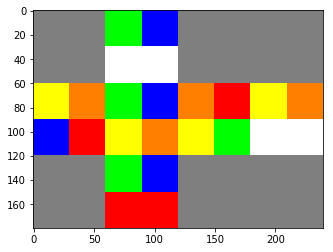

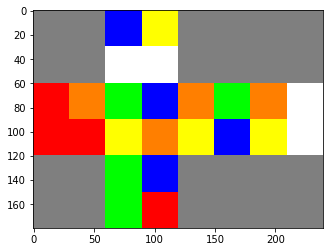

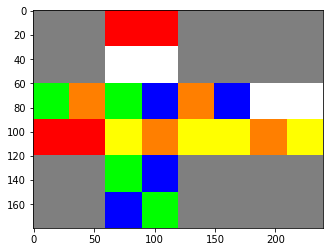

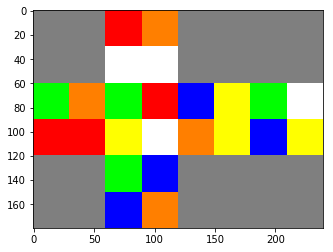

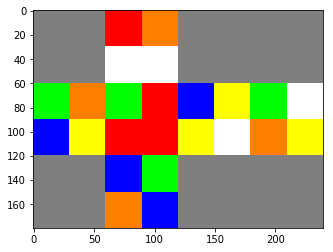

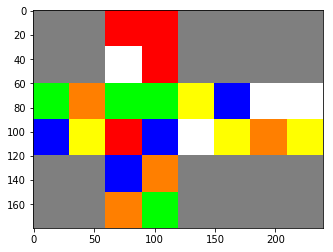

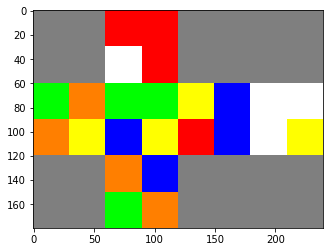

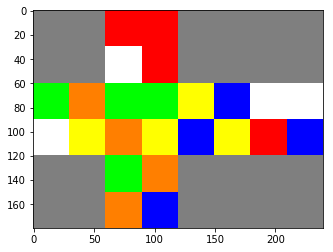

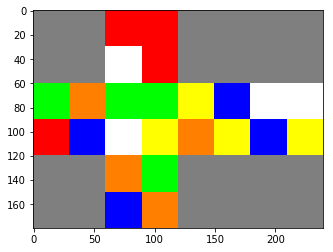

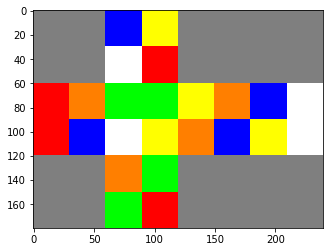

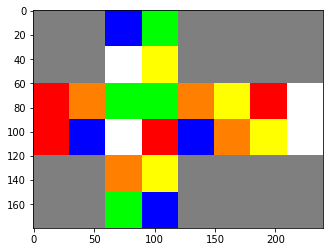

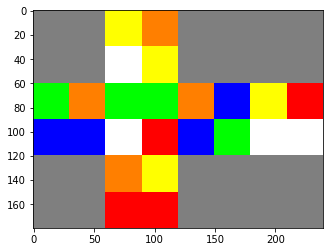

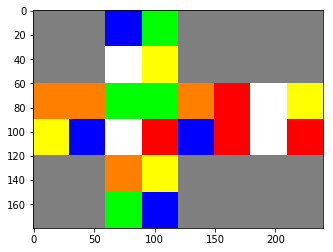

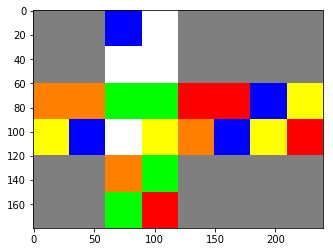

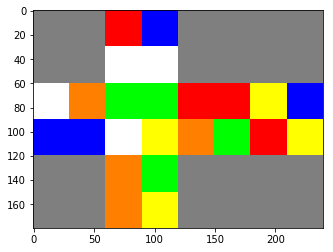

In [139]:
random_moves = np.random.randint(0,6,1000)
network = torch.load('./models/' + 'LBF_14' + '/model.pt', map_location='cpu')
network.to(device)

for i in range(1000):
    env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=420)
    env.reset(1000)
    hashes = defaultdict(list)
    done = 0
    tries = 0
    max_tries = 1000
    t = time.time()
    state = env.get_observation()
    hashes[hash(state.tostring())] = [0]*env.action_space.n
    stop = False
    solution_sequence = []
    state_hash_seq = []

    while time.time()-t<1.21 and not done and not stop:
        mask = hashes[hash(state.tostring())]
        state_hash_seq.append(hash(state.tostring()))
        action = network.act(state, 0.0, mask, device)
        solution_sequence.append(action)

        next_state, reward, done, info = env.step(action)  

        hstate = state.copy()
        state = next_state
        h = hash(state.tostring())
        if h in hashes.keys():      
            hashes[hash(hstate.tostring())][action] = -999
        else:
            hashes[h] = [0]*env.action_space.n

        tries += 1
        if max_tries:
            if tries >= max_tries:
                stop = True
    
    if not done:
        break
    else:
        print(i)
        
    length, first_idx = maxDistance(state_hash_seq)
                        
    while length > 0:
        state_hash_seq = state_hash_seq[:first_idx] + state_hash_seq[first_idx + length:]
        solution_sequence = solution_sequence[:first_idx] + solution_sequence[first_idx + length:]
        length, first_idx = maxDistance(state_hash_seq)
        
env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=420)
for j in range(i + 1):
    env.step(int(random_moves[j]))

for move in solution_sequence:
    env.render()
    env.step(move)

env.render()

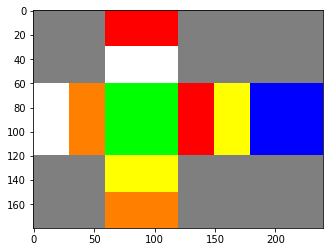

In [21]:
env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=420)
env.reset(1000)
env.reset(1)
env.render()


NameError: name 'torch' is not defined